In [1]:
import h5py
import pickle
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import sklearn.decomposition
from  sklearn.decomposition import PCA
from  sklearn.manifold import TSNE

import sklearn.cluster
import matplotlib.image as mpimg
from PIL import Image as im
from skimage import data
from skimage.filters import try_all_threshold
from matplotlib import cm
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import correlation
from sklearn.metrics.pairwise import euclidean_distances
from mpl_toolkits.axes_grid1 import make_axes_locatable


## Loading Data

In [2]:
#we would like to retrieve and collect the spatial components across all specimens and sessions 

#we state the name of the specimens
specimen_names = ['mSM30','mSM34','mSM36', 'mSM46','mSM57']

#then add the dates that the dates each subject was subject to experiment
dates = np.array([['10-Oct-2017','12-Oct-2017'],
                 ['01-Dec-2017','01-Dec-2017'],
                 ['05-Dec-2017','07-Dec-2017'],
                 ['01-Dec-2017','13-Jan-2018'],
                 ['02-Feb-2018','08-Feb-2018']])


#then add the data type of the files 
file_extension0 = 'data.hdf5'
file_extension1 = 'neural_nmfsupp.mat'

num_specimens = len(specimen_names); max_sessions = len(dates[0])

#then form the file names
annotations = np.empty(shape=(max_sessions, num_specimens),dtype=object)
file_names0 = np.empty(shape=(max_sessions, num_specimens),dtype=object)
file_names1 = np.empty(shape=(max_sessions, num_specimens),dtype=object)

for i in range(num_specimens):
    specimen = specimen_names[i]
    for j in range(max_sessions):
        date = dates[i][j]
        annotations[j][i] = specimen + '/' + date
        file_names0[j][i] = "./" + specimen + '/' + date + '/' + file_extension0 #data
        file_names1[j][i] = "./" + specimen + '/' + date + '/' + file_extension1 #neuralnmf
        


file_names0_flat = file_names0.flatten('F'); file_names1_flat = file_names1.flatten('F'); annotations_flat = annotations.flatten('F')
#then make a 4d array to hold all the locanmf spatial data 
spatials = []

#generate a list of matrices 
for i in range (file_names1_flat.shape[0]):
    neural_nmf =sio.loadmat(file_names1_flat[i])
    spatials.append(neural_nmf['A'])

#collect neural instances
regions = []
for i in range(file_names0_flat.shape[0]):
    data = h5py.File(file_names0_flat[i], 'r')
    regions.append(data['regions'])

print("these are the available regions:");
print(list(data['regions']['indxs_consolidate_lr'].keys()));


    


these are the available regions:
['ACAd1_L', 'ACAd1_R', 'AUD_R', 'FRP1_L', 'FRP1_R', 'MOB_L', 'MOB_R', 'MOp_L', 'MOp_R', 'MOs_L', 'MOs_R', 'PL1_L', 'PL1_R', 'RSP_L', 'RSP_R', 'SSp_L', 'SSp_R', 'SSs1_L', 'SSs1_R', 'VIS_L', 'VIS_R']


## Collect Pertinent Dimensions

In [33]:
#we first seek to collect the locanmf dimensions of a region across all sessions/specimens

#we select a given region and then collect the locanmf dimensions that correspond to a given region across all specimens/trials



def dim_reduction(r, low_bound):
    r = 'MOs_R', low_bound=0.8 
    print("this is our selected region and low bound: ", r,low_bound);
    sregions=[] # an array that will hold 3d image matrices (one for each session) only in our region of interest
    sregions_label = []
    num_dimensions = []
    #print("collecting pertinent dimensions across sessions");
    for i in range(len(file_names0_flat)):
        start_dimension = regions[i]['indxs_consolidate_lr'][r][0][0] #first locanmf dimension of region
        end_dimension = regions[i]['indxs_consolidate_lr'][r][0][-1]  #last locanmf dimension of region
        sregions.append(spatials[i][:,:,start_dimension:end_dimension])
        sregions_label += (spatials[i][:,:,start_dimension:end_dimension].shape[2]) * [annotations_flat[i]]
        num_dimensions.append((spatials[i][:,:,start_dimension:end_dimension].shape[2]))
        #print(sregions[i].shape);
    #print("concatenating image matrices (forming one big array)  new shape:");
    s = np.dstack(sregions)
    #print(s.shape);
    mean_num_dimensions = np.mean(num_dimensions)
    std_num_dimensions = np.std(num_dimensions)
    #print("mean number of dimensions: ", mean_num_dimensions)
    # we now seek to remove those pixels from images that have 0 values across all sessions
    low_bound = low_bound #brightness of pixel that determines if it is relevant enough to keep

    s = np.nan_to_num(s)
    s_r = s.reshape(-1, s.shape[-1])
    #print("s reshaped (flat): ", s_r.shape)

    #find row where all values are below tolerance 
    zero_rows = np.all(s_r<low_bound, axis=1)
    s_r_d = s_r[~np.all(s_r<low_bound, axis=1)]

    #print("s reduced size: ", s_r_d.shape)
    return s_r_d, sregions_label, mean_num_dimensions,std_num_dimensions,s






SyntaxError: cannot assign to literal (<ipython-input-33-d83b63a9673e>, line 8)

## Visualize Reduced Size Components 

In [35]:
low_bounds = [0.6,0.7,0.8]
num_pix_i=540*600
#a_regions = ['MOB_R', 'MOp_R','MOs_L']
a_regions=list(data['regions']['indxs_consolidate_lr'].keys())

fin_pix_num = [[100.0*(dim_reduction(a_region,lb)[0].shape[0])/num_pix_i for a_region in a_regions] for lb in low_bounds]
print(fin_pix_num)

x = np.arange(len(a_regions))  # the label locations
width = 0.2  # the width of the bars

fig, ax = plt.subplots(figsize=(15,15))
rects1 = ax.bar(x - width, fin_pix_num[0], width, label=low_bounds[0])
rects2 = ax.bar(x , fin_pix_num[1], width, label=low_bounds[1])
rects3 = ax.bar(x + width, fin_pix_num[2], width, label=low_bounds[2])

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent remaining pixels (%)'); ax.set_xlabel('Regions')
ax.set_title('Number of remaining pixels vs low bound pixel value')
ax.set_xticks(x)
ax.set_xticklabels(a_regions)
ax.legend()



#fig.tight_layout()
plt.savefig("npix_v_lb")
plt.show()



this is our selected region and low bound:  ACAd1_L 0.6


TypeError: string indices must be integers

this is our selected region and low bound:  MOB_R 0.8


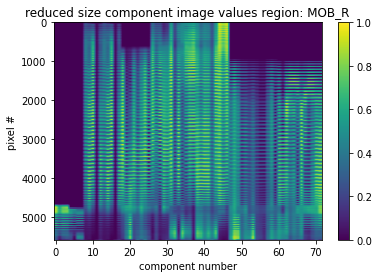

this is our selected region and low bound:  MOs_R 0.8


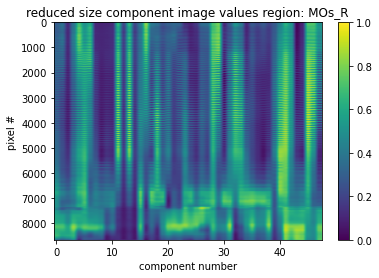

this is our selected region and low bound:  SSp_R 0.8


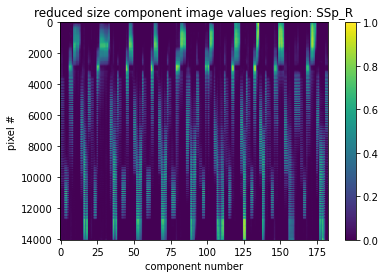

In [5]:
def vis_red_dim(r,low_bound):
    s_r_d , l, n, z, a = dim_reduction(r, low_bound=0.8)
    
    c = plt.imshow(s_r_d,aspect='auto',cmap="viridis",vmax=1, vmin=0)
    plt.ylabel("pixel #"); plt.xlabel("component number"); plt.title("reduced size component image values region: {}".format(r))
    plt.colorbar(c)
    plt.savefig("retainedpix{}".format(r))
    
    plt.show()

rs = ['MOB_R','MOs_R','SSp_R']
for  r in rs:
    s_r_d , l, n, z, a = dim_reduction(r, low_bound=0.8)
    c = plt.imshow(s_r_d,aspect='auto',cmap="viridis",vmax=1, vmin=0)
    plt.ylabel("pixel #"); plt.xlabel("component number"); plt.title("reduced size component image values region: {}".format(r))
    plt.colorbar(c)
    plt.savefig("retainedpix{}".format(r))
    
    plt.show()


## Run tSNE Visual Clustering 

In [26]:
#r = 'MOs_R'; lb = 0.8 # MOp_L, MOs_L, Vis_L
def run_tsne(r,lb):
    s_r_d, sregions_label, mean_num_dimensions, std_num_dimension,s = dim_reduction(r,lb) 
    tsne = sklearn.manifold.TSNE(2,init='pca',perplexity=mean_num_dimensions)
    s_r_d_embedded = tsne.fit_transform(s_r_d.T)
    print("s_r_d_embedded shape: ", s_r_d_embedded.shape)
    scatter_x = s_r_d_embedded[:,0]; scatter_y = s_r_d_embedded[:,1]; #scatter_z = s_r_d_embedded[:,2]

    fig  = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot()
    #ax = fig.add_subplot(projection='3d')
    plt.title("TSNE of LocaNMF Dimension Images for region {} and lower bound {}".format(r, lb))
    for g in range(len(annotations_flat)):
        index_array = [i for i in range(len(sregions_label)) if sregions_label[i] == annotations_flat[g]]
        #rint(len(index_array))
        for i in range(len(index_array)):
            ax.scatter(scatter_x[index_array[i]],scatter_y[index_array[i]] , label = annotations_flat[g],s=70,marker='${}$'.format(index_array[i]))
        #ax.scatter(scatter_x[index_array],scatter_y[index_array] ,label = annotations_flat[g],s=50,marker='${}$'.format(*index_array))
        print(index_array)


    plt.legend(bbox_to_anchor=(1.05, 1),ncol=5)
    plt.savefig("tsne_{}".format(r))
    plt.show()


In [34]:
regions = ['MOp_L', 'MOs_L', 'VIS_L']; lb = 0.8 # MOp_L, MOs_L, Vis_L

r = 'MOp_L'
run_tsne(r,lb)

this is our selected region and low bound:  MOp_L 0.8


TypeError: string indices must be integers

In [7]:

def visualize_clusters(iois):
    figure, axes = plt.subplots(nrows=len(ioi),figsize=(25, 25))
    for i in range(len(ioi)):
        plt.sca(axes[i])
        axes[i].title.set_text(ioi[i])
        axes[i].imshow(s[:,:,ioi[i]])
    plt.savefig("roi")


In [8]:
## we now evaluate the wasserstein "earth movers", spatial correlation, and euclidean distance between the images in the cluster
def calc_distances(ioi):
    n = len(ioi); num_pairs = (int)((n*(n-1))/2)

    em_distances = np.zeros(shape = (n,n))
    sc_distances = np.zeros(shape = (n,n)) 
    eu_distances = np.zeros(shape = (n,n))
    
    print(s_r_d.shape, s_r_d[:,ioi[0]].shape)
    for i in range(n):
        for j in range(n):
            em_distances[i][j]= wasserstein_distance(s_r_d[:,ioi[i]],s_r_d[:,ioi[j]])
            sc_distances[i][j]= correlation(s_r_d[:,ioi[i]],s_r_d[:,ioi[j]])
            eu_distances[i][j]= euclidean_distances((s_r_d[:,ioi[i]].T).reshape(1,-1),(s_r_d[:,ioi[j]].T).reshape(1,-1))
    #em_distances = em_distances/np.linalg.norm(em_distances)
    #sc_distances = sc_distances/np.linalg.norm(sc_distances)
    #eu_distances = eu_distances/np.linalg.norm(eu_distances)
    return em_distances, sc_distances, eu_distances



(8659, 48) (8659,)
(8659, 48) (8659,)
(8659, 48) (8659,)


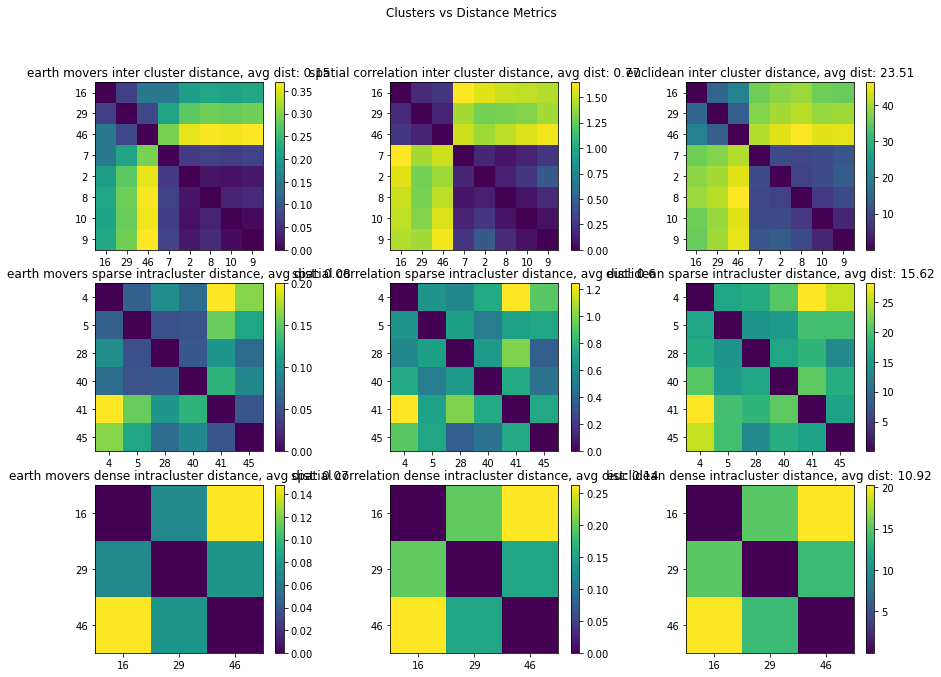

In [14]:
fig, axs = plt.subplots(3,3)
fig.set_size_inches(15, 10.5)
iois = [[16, 29, 46, 7, 2, 8, 10,9], [4,5,28,40,41,45], [16, 29, 46]]; 
iois_labels = ["inter cluster ", "sparse intracluster ", "dense intracluster "]
distance_labels = ["earth movers ", "spatial correlation ", "euclidean "]
distances = [calc_distances(ioi) for ioi in iois]
for i in range(len(distances)):
    for j in range(3):
         avg_distance = str(np.round(np.average(distances[i][j]),2))
         im =axs[i][j].imshow(distances[i][j], interpolation='None') 
         plt.sca(axs[i][j])
         plt.xticks(np.arange(len(iois[i])), iois[i])
         plt.yticks(np.arange(len(iois[i])), iois[i])
         axs[i][j].title.set_text(distance_labels[j]+iois_labels[i]+"distance, avg dist: " + avg_distance)
         plt.colorbar(im, ax=axs[i, j])
plt.suptitle('Clusters vs Distance Metrics')
#plt.show()
plt.savefig("cluster_vs_distmetric")

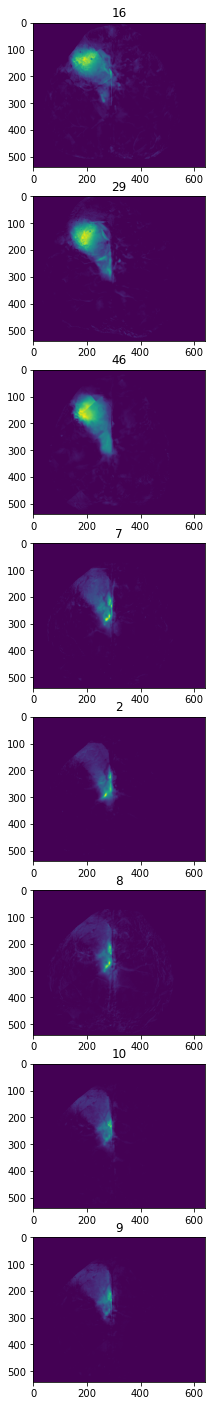

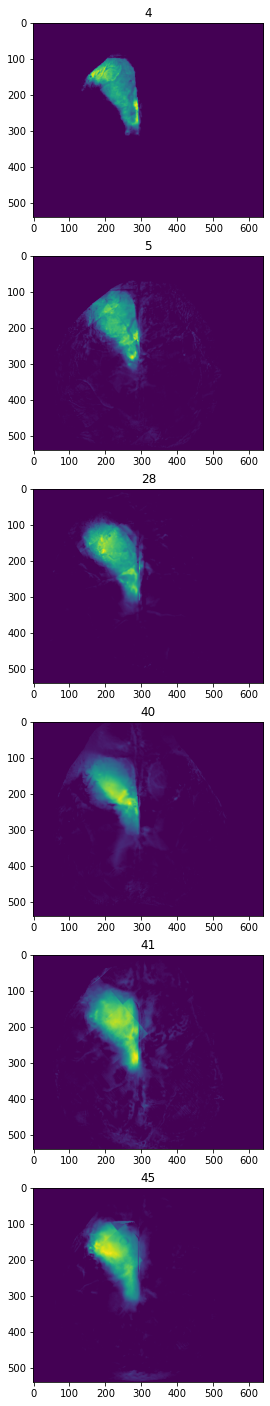

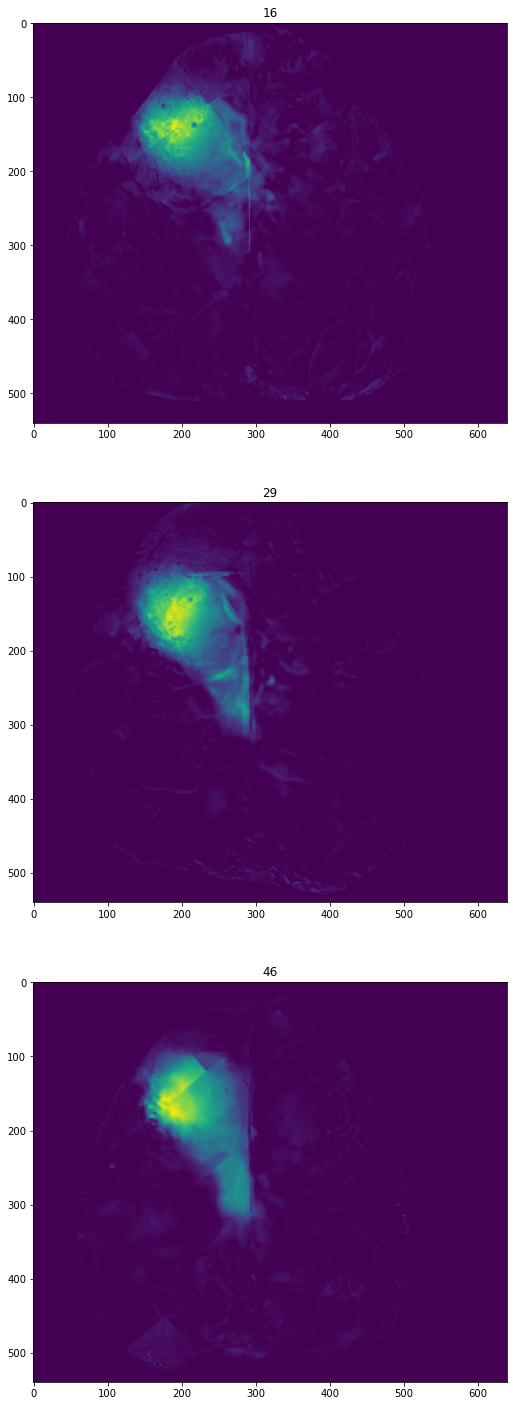

In [16]:
for ioi in iois:
    visualize_clusters(ioi)



We can see that the 

## Image Reconstruction
### use reconstruction to evaluate how representative tSNE clusters actually are 


## Kmeans and DBSCAN 

We choose 10 components
pc_feats_norm shape (48, 10)


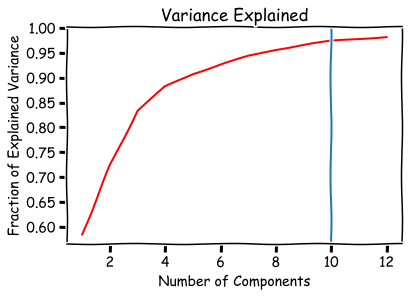

In [66]:
## What number of components explain most variance?
num_comps = 12
pca = PCA(n_components=num_comps)
pca.fit(s_r_d.T/np.linalg.norm(s_r_d.T))
cumsums = np.array([np.sum(pca.explained_variance_ratio_[:i]) for i in range(num_comps)])
ideal_num_comps = np.argwhere(cumsums > 0.97)
ideal_num_comp= int(ideal_num_comps[0])
#
###

## plot the variance explained ratio, and pick the number of PCs that reach ~90% variance explained
with plt.xkcd(scale=0.5):
    plt.plot(np.arange(num_comps)+1,np.cumsum(pca.explained_variance_ratio_),c="r")
    plt.axvline(x=ideal_num_comps[0])
    plt.title("Variance Explained"); plt.ylabel("Fraction of Explained Variance"); plt.xlabel("Number of Components")
    print("We choose {} components".format(ideal_num_comp))
plt.savefig("pca_plot")
## We first perform pca on the reduced dimensinoality representation of the 
pca = PCA(n_components = ideal_num_comp)
pc_feats = pca.fit_transform(s_r_d.T)
pc_feats_norm = pc_feats/np.linalg.norm(pc_feats)
print("pc_feats_norm shape",pc_feats_norm.shape)

In [67]:
def plot_clustering_2d(pc_feats_norm, y_predict, method_name):
    plt.figure()
    plt.title("{} Clustering of PC Feats of Reduced Images".format(method_name))
    #plt.xlabel("pc comp 1")
    #plt.ylabel("pc comp 2")
    plt.scatter(pc_feats_norm[:, 0],pc_feats_norm[:, 1],c=y_predict,cmap='Paired')
    plt.show()
    plt.savefig(method_name)

In [68]:
def plot_clustering_3d(pc_feats_norm, y_predict, method_name):
    fig = plt.figure(figsize=(15,15))
   # plt.xlabel("PC1"); plt.ylabel("PC2"); plt.ylabel("PC3")
    ax = fig.add_subplot(projection='3d')
    ax.scatter(pc_feats_norm[:, 0], pc_feats_norm[:, 1], pc_feats_norm[:, 2],c=y_predict,cmap='Paired')
    plt.show()

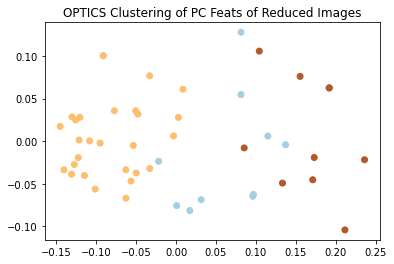

<Figure size 432x288 with 0 Axes>

In [81]:
y_predict_optics= sklearn.cluster.OPTICS(min_cluster_size=int(mean_num_dimensions+std_num_dimension),metric='correlation').fit_predict(pc_feats_norm)
plot_clustering_2d(pc_feats_norm, y_predict_optics, "OPTICS")

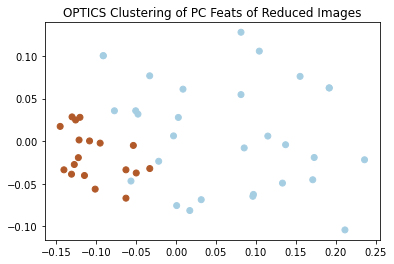

<Figure size 432x288 with 0 Axes>

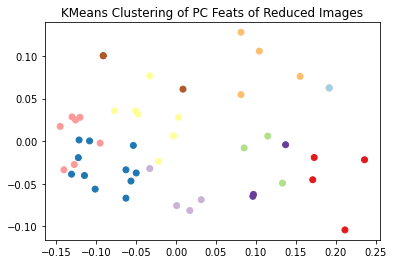

<Figure size 432x288 with 0 Axes>

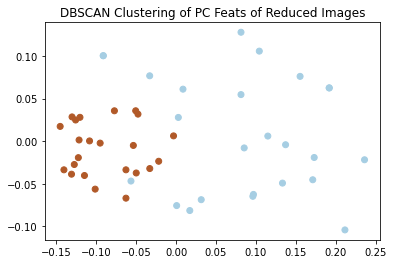

<Figure size 432x288 with 0 Axes>

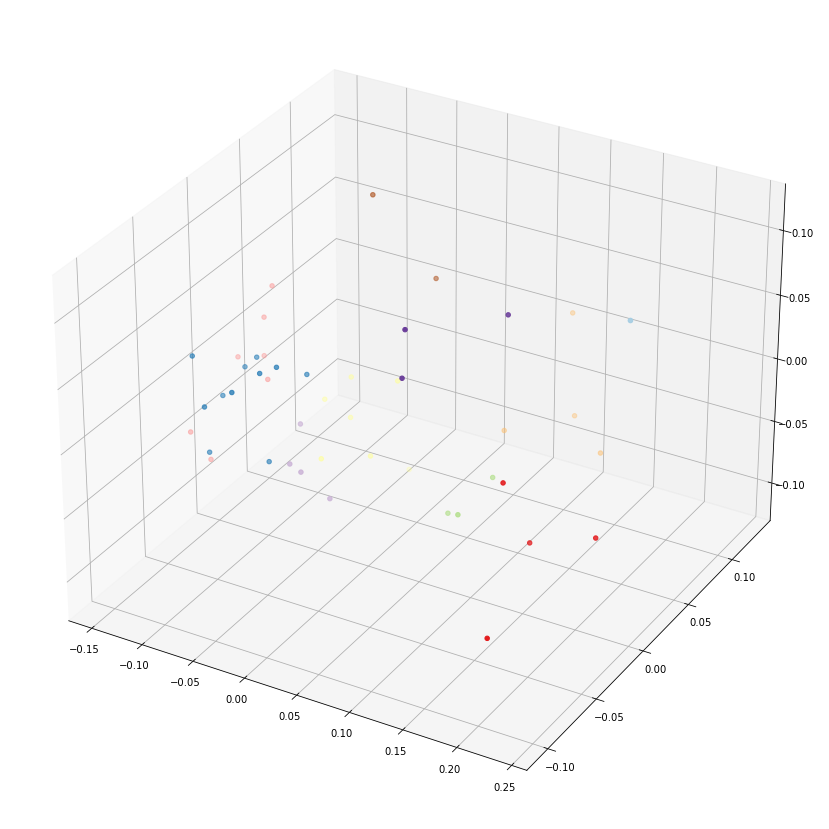

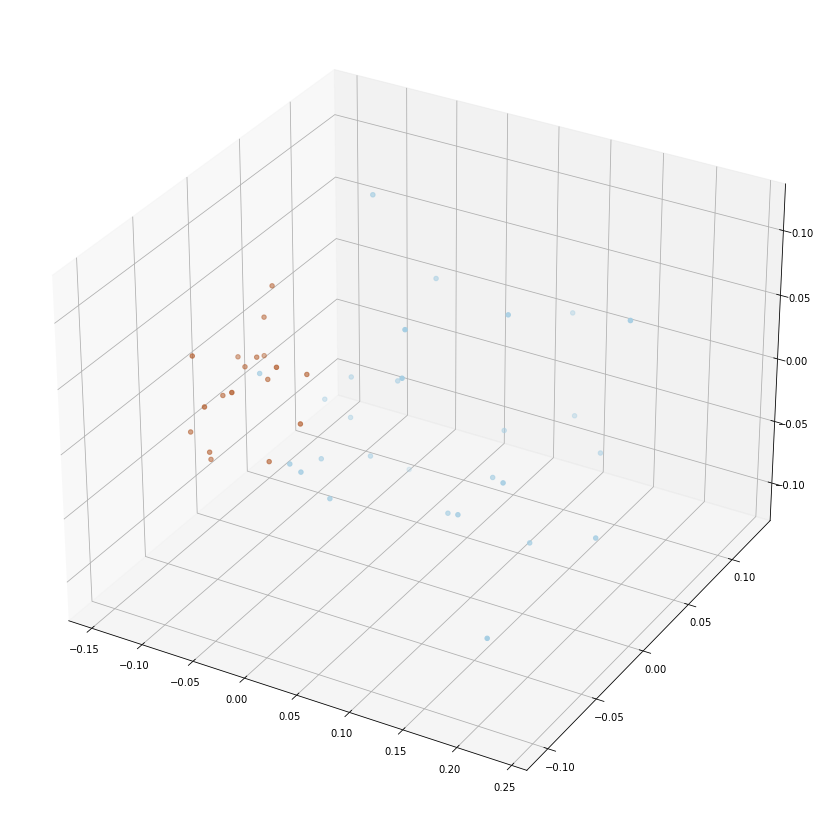

NameError: name 'indices' is not defined

In [71]:

#optics = sklearn.cluster.OPTICS(min_cluster_size=int(mean_num_dimensions+std_num_dimension),max_eps=0.09).fit(pc_feats_norm)
y_predict_optics= sklearn.cluster.OPTICS(min_cluster_size=int(mean_num_dimensions+std_num_dimension),max_eps=0.09).fit_predict(pc_feats_norm)
y_predict_kmeans= sklearn.cluster.KMeans(n_clusters=10,tol=1.5*1e-3,n_init=50,max_iter=700).fit_predict(pc_feats_norm)
y_predict_dbscan = sklearn.cluster.DBSCAN(eps=0.095,min_samples=mean_num_dimensions).fit_predict(pc_feats_norm)

#correlation distance
#

plot_clustering_2d(pc_feats_norm, y_predict_optics, "OPTICS")
plot_clustering_2d(pc_feats_norm,y_predict_kmeans,"KMeans")
plot_clustering_2d(pc_feats_norm, y_predict_dbscan, "DBSCAN")
plot_clustering_3d(pc_feats_norm,y_predict_kmeans,"KMeans")
plot_clustering_3d(pc_feats_norm, y_predict_optics, "OPTICS")
loi = 1
indices_op = [i for i in range(y_predict_optics.shape[0]) if y_predict_optics[i]==loi]
indices_km = [i for i in range(y_predict_kmeans.shape[0]) if y_predict_kmeans[i]==loi]
indices_db = [i for i in range(y_predict_dbscan.shape[0]) if y_predict_dbscan[i]==loi]


figure, axes = plt.subplots(nrows=len(indices),figsize=(70, 70))
plt.legend()
for i in range(len(indices)):
    axes[i].imshow(s[:,:,indices[i]])
plt.savefig("roi_dbscan")


No handles with labels found to put in legend.


pc_feats shape (48, 5)
(48, 5)
labels shape (48,)
[ 0  1  2  0  3  4  5  2  2  2  2  6  7  6  7  8  9 10 11 12 13 14 15 16
 17 18 12 19 20 21 22 16 23 11 12 24 25 25 26 27 28 29 30 31 31 32 33 34]


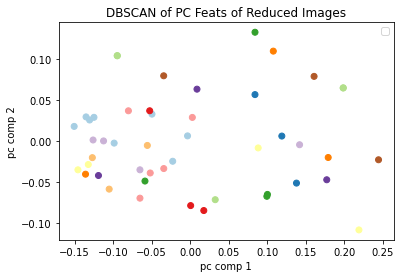

(48,)
[1]


TypeError: 'AxesSubplot' object is not subscriptable

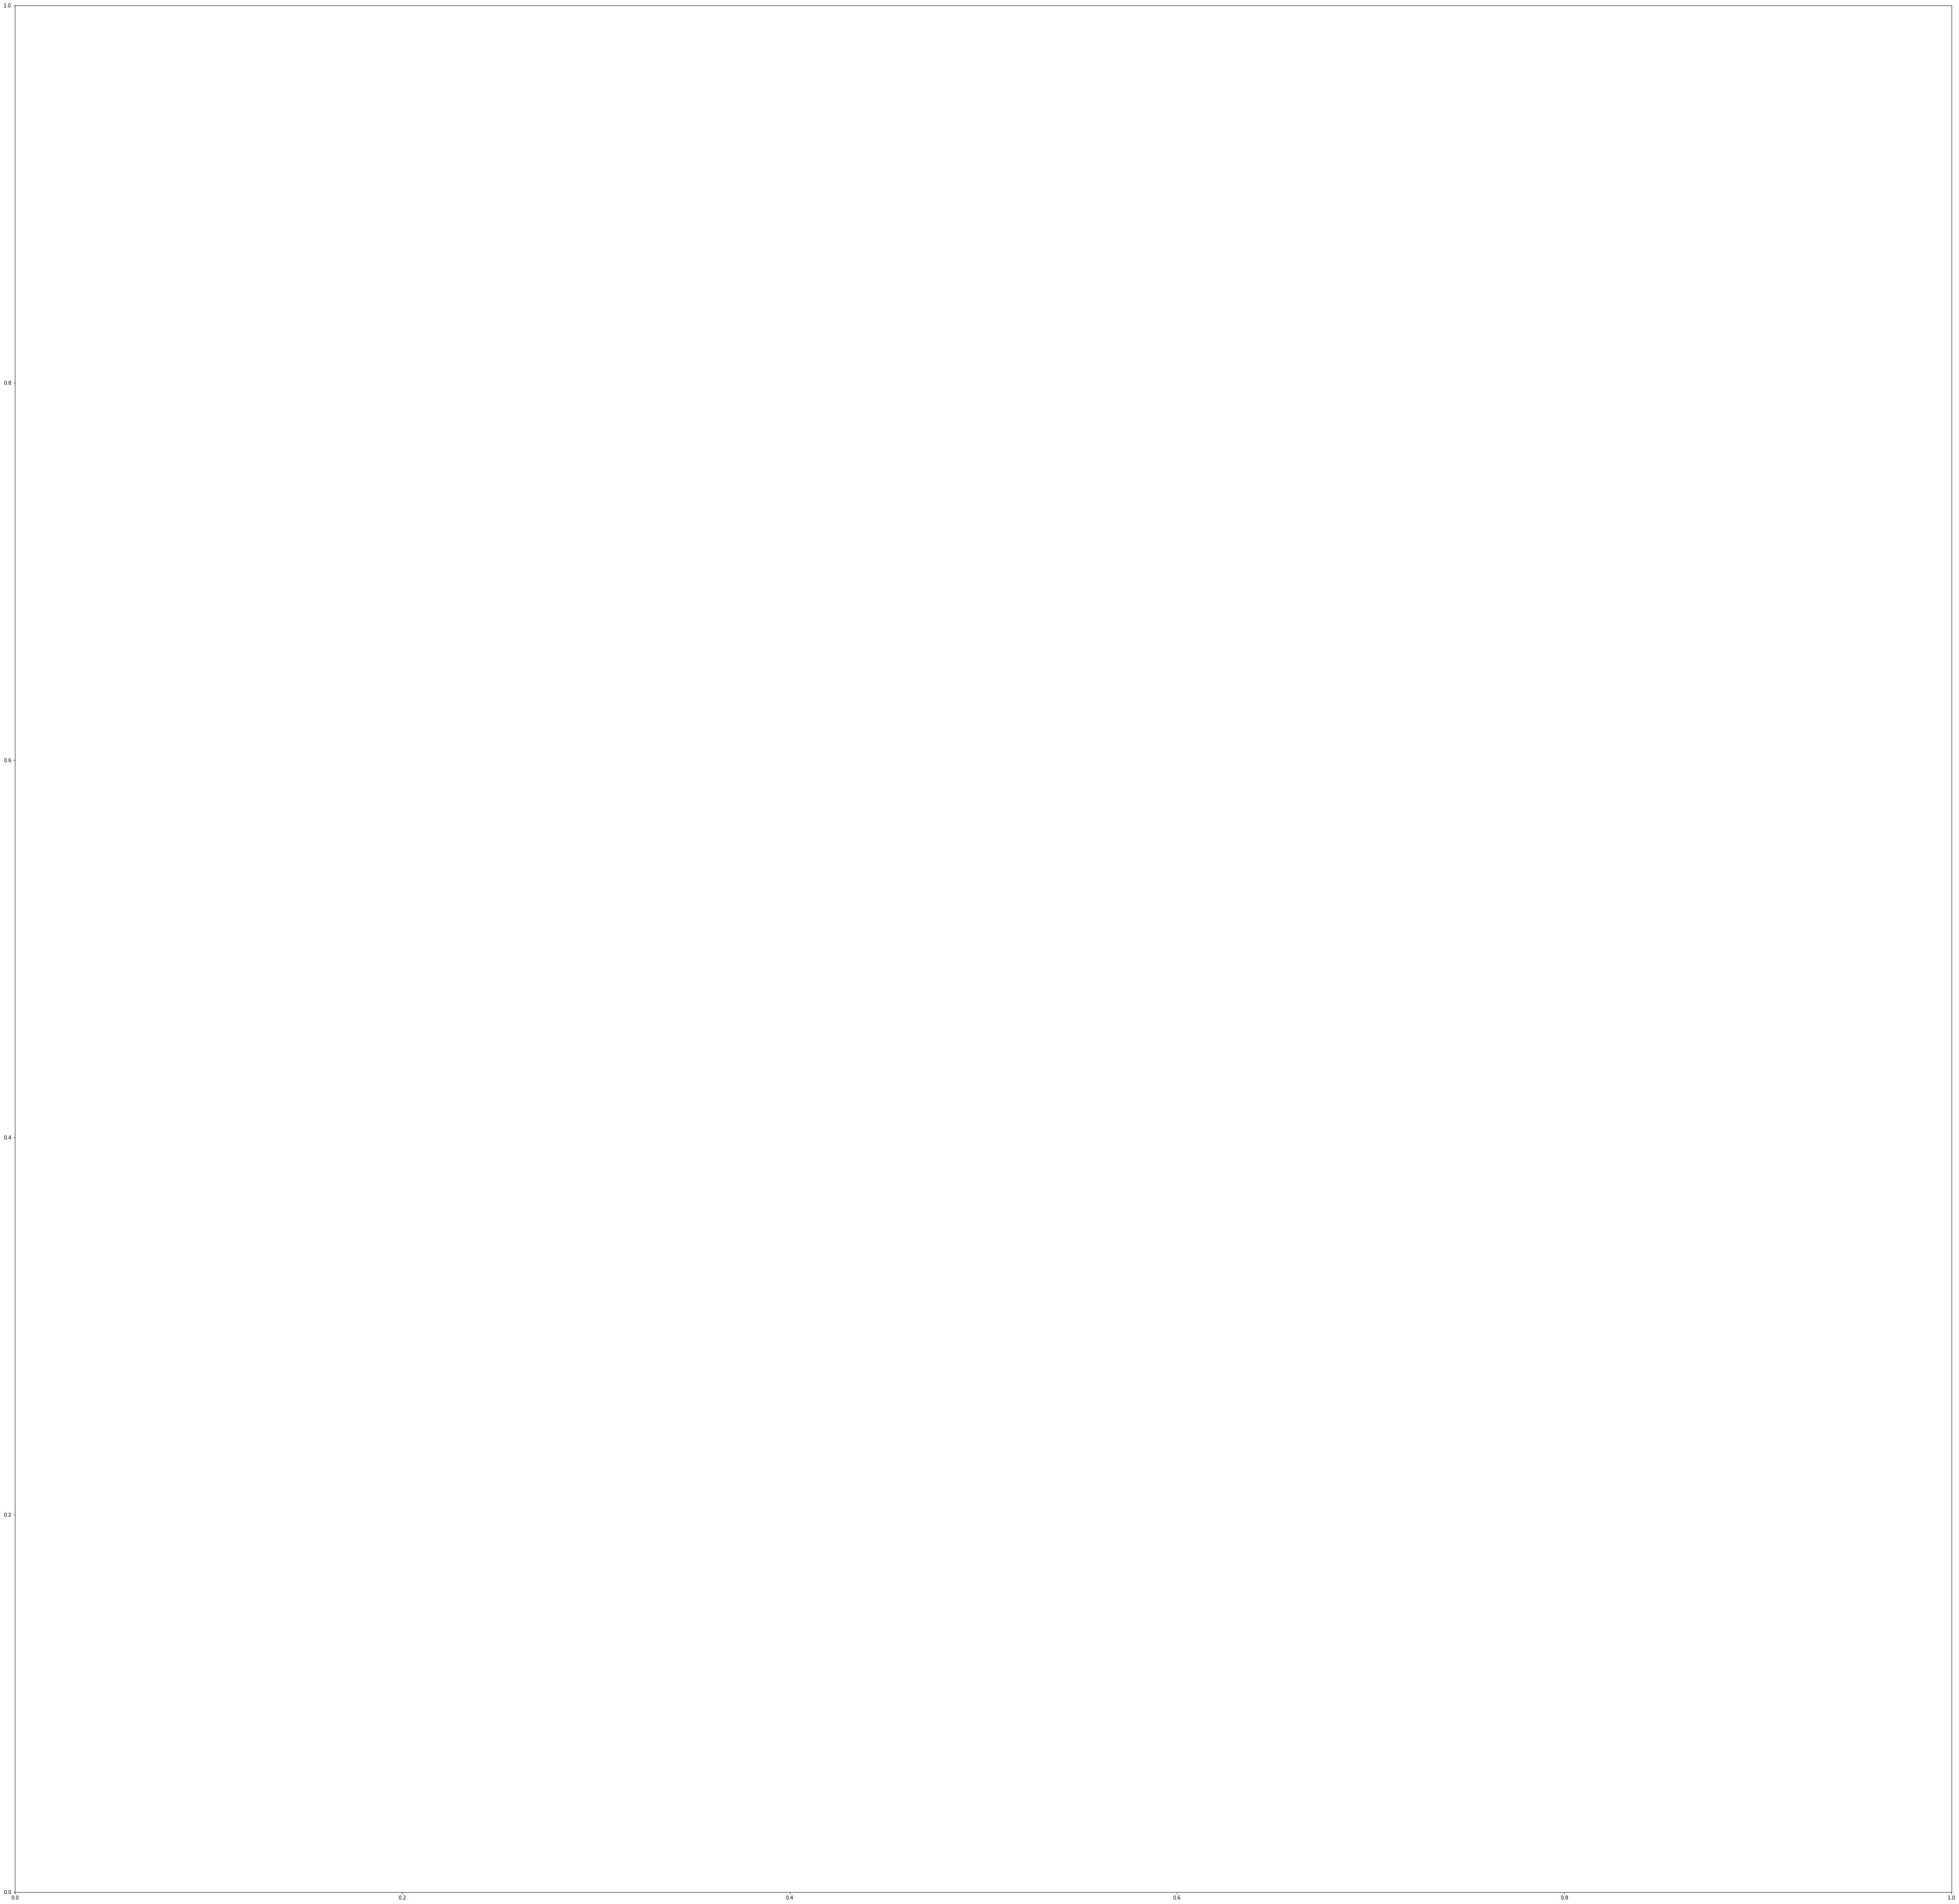

In [16]:
## plot PCA - > KMeans Clustering 

